<b><u>PREP DATA</u></b>   
Import dataset
Drop OXSM singlet (lack of space on mass spec for replicate of this clone

In [1]:
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
import scipy.stats as stats
import sys
import seaborn as sns
sns.set(font='arial')
jakes_cmap = sns.diverging_palette(212, 61, s=99, l=77, sep=1, n=16, center='dark') #Custom aesthetics
import xpressplot as xp

In [2]:
# Read in csv (already has a genometric mean normalization applied)
df = pd.read_csv("/Users/jordan/Desktop/collaborations/mtfas_nowinski/mtfas_sum.csv",sep=",")
df = df[['Gene Symbol','GFP5-1 Sum','GFP5-2 Sum','GFP9-1 Sum','GFP9-2 Sum','Me2.14-1 Sum','Me2.14-2 Sum','Me3.8-1 Sum','Me3.8-2 Sum','O2.9-1 Sum','O2.9-2 Sum']]
df = df.dropna(axis=0)

In [3]:
df_oxsm = df[['Gene Symbol','GFP5-1 Sum','GFP5-2 Sum','GFP9-1 Sum','GFP9-2 Sum','O2.9-1 Sum','O2.9-2 Sum']]
df_mecr = df[['Gene Symbol','GFP5-1 Sum','GFP5-2 Sum','GFP9-1 Sum','GFP9-2 Sum','Me2.14-1 Sum','Me2.14-2 Sum','Me3.8-1 Sum','Me3.8-2 Sum']]

df_oxsm = df_oxsm.set_index('Gene Symbol')
df_mecr = df_mecr.set_index('Gene Symbol')

In [4]:
df_oxsm.mean(axis=0)

GFP5-1 Sum    1389.076124
GFP5-2 Sum    1389.514343
GFP9-1 Sum    1389.547701
GFP9-2 Sum    1389.103826
O2.9-1 Sum    1389.088495
O2.9-2 Sum    1389.793508
dtype: float64

In [5]:
df_mecr.mean(axis=0)

GFP5-1 Sum      1389.076124
GFP5-2 Sum      1389.514343
GFP9-1 Sum      1389.547701
GFP9-2 Sum      1389.103826
Me2.14-1 Sum    1388.877011
Me2.14-2 Sum    1389.368541
Me3.8-1 Sum     1389.171612
Me3.8-2 Sum     1389.771066
dtype: float64

<b><u>SCALE GENES FOR HEATMAP</u></b>    
Used a different methodology where I split up the dataframe to GFP + MECR and GFP + OXSM and then scaled datasets   
Used original sum datasheet where metrics not normalized yet   
Whether or not this works is still debatable, but if not using heatmaps for publication, not an issue   
Volcano plots are unchanged by this method as they are not scaled   

In [6]:
###CHECK IF THIS IS OKAY
#Average every two cols together

df_mecr['GFP_b1'] = df_mecr[['GFP5-1 Sum','GFP5-2 Sum']].mean(axis=1)
df_mecr['GFP_b2'] = df_mecr[['GFP9-1 Sum','GFP9-2 Sum']].mean(axis=1)
df_mecr['MECR_b1'] = df_mecr[['Me2.14-1 Sum','Me2.14-2 Sum']].mean(axis=1)
df_mecr['MECR_b2'] = df_mecr[['Me3.8-1 Sum','Me3.8-2 Sum']].mean(axis=1)

df_oxsm['GFP_b1'] = df_oxsm[['GFP5-1 Sum','GFP5-2 Sum']].mean(axis=1)
df_oxsm['GFP_b2'] = df_oxsm[['GFP9-1 Sum','GFP9-2 Sum']].mean(axis=1)
df_oxsm['OXSM_b1'] = df_oxsm[['O2.9-1 Sum','O2.9-2 Sum']].mean(axis=1)

df_mecr = df_mecr[['GFP_b1','GFP_b2','MECR_b1','MECR_b2']]
df_oxsm = df_oxsm[['GFP_b1','GFP_b2','OXSM_b1']]

#Scale proteins
df_mecr_scaled = df_mecr.copy()
df_mecr_scaled[df_mecr_scaled.columns] = preprocessing.scale(df_mecr_scaled[df_mecr_scaled.columns],axis=1)
df_mecr_scaled.mean(axis=1).head()

df_oxsm_scaled = df_oxsm.copy()
df_oxsm_scaled[df_oxsm_scaled.columns] = preprocessing.scale(df_oxsm_scaled[df_oxsm_scaled.columns],axis=1)
df_oxsm_scaled.mean(axis=1).head()

Gene Symbol
Tbc1d25    1.702342e-15
Cul4b      2.960595e-16
Dhx8       0.000000e+00
Pgap3      6.476301e-16
Arfgef2    5.366078e-15
dtype: float64

In [7]:
df_mecr_logFC = df_mecr.copy()
del df_mecr_logFC.index.name
df_mecr_logFC['gfp_mean'] = df_mecr_logFC[['GFP_b1','GFP_b2',]].mean(axis=1)
df_mecr_logFC = df_mecr_logFC[['GFP_b1','GFP_b2','MECR_b1','MECR_b2']].div(df_mecr_logFC.gfp_mean, axis=0)
df_mecr_logFC = np.log2(df_mecr_logFC)
df_mecr_logFC['base'] = df_mecr_logFC[['GFP_b1','GFP_b2']].mean(axis=1)
df_mecr_logFC = df_mecr_logFC[~df_mecr_logFC.index.duplicated()]
df_mecr_logFC = df_mecr_logFC[['GFP_b1','GFP_b2','MECR_b1','MECR_b2']].subtract(df_mecr_logFC.base, axis=0)

df_oxsm_logFC = df_oxsm.copy()
del df_oxsm_logFC.index.name
df_oxsm_logFC['gfp_mean'] = df_oxsm_logFC[['GFP_b1','GFP_b2',]].mean(axis=1)
df_oxsm_logFC = df_oxsm_logFC[['GFP_b1','GFP_b2','OXSM_b1']].div(df_oxsm_logFC.gfp_mean, axis=0)
df_oxsm_logFC = np.log2(df_oxsm_logFC)
df_oxsm_logFC['base'] = df_oxsm_logFC[['GFP_b1','GFP_b2']].mean(axis=1)
df_oxsm_logFC = df_oxsm_logFC[~df_oxsm_logFC.index.duplicated()]
df_oxsm_logFC = df_oxsm_logFC[['GFP_b1','GFP_b2','OXSM_b1']].subtract(df_oxsm_logFC.base, axis=0)

In [8]:
df_all_fc = df_oxsm_logFC.copy()

df_all_fc['MECR_b1'] = df_mecr_logFC['MECR_b1']
df_all_fc['MECR_b2'] = df_mecr_logFC['MECR_b2']
df_all_fc.columns = [
    'GFP 1',
    'GFP 2',
    'Oxsm (O2-9)',
    'Mecr 1 (Me2-14)',
    'Mecr 2 (Me3-8)',
]

<b><u>CREATE GENE LISTS</u></b>

In [9]:
# Select proteins of interest
n_module = ['Ndufv1','Ndufv2','Ndufs1','Ndufa2','Ndufs4',
            'Ndufa12','Ndufs6','Ndufv3']
q_module = ['Ndufa6','Ndufa7','Ndufa5','Ndufs2',
            'Ndufs3','Ndufs7','Ndufs8','Ndufa9']
p_module = ['Mtnd1','Ndufa3','Ndufa8','Ndufa13','Ndufa1',
            'Mtnd3','Mtnd4l','Ndufc2','Ndufa10','Ndufs5',
            'Ndufa11','Ndufb6','Ndufb5','Ndufb10','Ndufb11',
            'Mtnd4','Ndufb4','Ndufb7','Ndufb3','Ndufb8',
            'Ndufb9','Ndufb2','Ndufs5']
pp_module = ['Mtnd1','Ndufa3','Ndufa8','Ndufa13','Ndufa1',
             'Mtnd4l','Mtnd3','Ndufc2','Ndufa10','Ndufs5',
             'Ndufa11']
pp1_module = ['Mtnd1','Ndufa3','Ndufa8','Ndufa13','Ndufa1']
pp2_module = ['Mtnd4l','Mtnd3','Ndufc2','Ndufa10','Ndufs5',
              'Ndufa11']
pd_module = ['Ndufb6','Ndufb5','Ndufb10','Ndufb11','Mtnd4',
             'Ndufb4','Ndufb7','Ndufb3','Ndufb8','Ndufb9',
             'Ndufb2']
pd1_module = ['Ndufb6','Ndufb5','Ndufb10','Ndufb11','Mtnd4',
             'Ndufb4']
pd2_module = ['Ndufb7','Ndufb3','Ndufb8','Ndufb9','Ndufb2']
complex_ii = ['Sdha','Sdhb','Sdhc']
complex_iii = ['Uqcrc2','Uqcrc1','Uqcrb','Uqcrq','Cyc1','Mt-CyB',
               'Uqcr10','Uqcrh','Uqcrfs1']
complex_iv = ['Mtco1','Cox5a','Cox5b','Cox6c','Mtco2',
              'Cox7a2','Cox7c','Cox6b1','Cox7a2l','Ndufa4',
              'Cox15']
complex_v = ['Atp5a1','Atp5b','Atp5c1','Atp5e','Atp5g2',
             'Mtatp6','Mtatp8','Atp5h','Atp5i','Atp5f1',
             'Atp5d','Atp5j2','Atp5j','Atp5l','Atp5o',
             'Atpif1']
fes_cluster = ['Lyrm4','Nfs1','Iscu']
lyr_proteins = ['Ndufa6','Ndufb9','Lyrm4']
lyr_targets = ['Sdhb','Uqcrfs1']

etc = n_module + q_module + pp_module + pd_module+ complex_ii + complex_iii + complex_iv + complex_v

In [10]:
mc = pd.read_csv("/Users/jordan/Desktop/collaborations/mtfas_nowinski/Mouse_MitoCarta2_0.csv",sep=",")

volcano_mitocarta = mc['Symbol'].tolist()

In [17]:
df_all_fc_heat.head()

,GFP 1,GFP 2,Oxsm (O2-9),Mecr 1 (Me2-14),Mecr 2 (Me3-8)
Ndufv1,-0.043779,0.043779,-0.801730,-0.436403,-0.656871
Ndufv2,-0.055667,0.055667,-0.785731,-0.401816,-0.686934
Ndufs1,-0.067437,0.067437,-0.621450,-0.189544,-0.523744
Ndufa2,-0.131366,0.131366,-0.860606,-0.277896,-0.306778
Ndufs4,-0.147193,0.147193,-1.534143,-0.415273,-1.004776


<b><u>HEATMAPS</u></b>

/Users/jordan/miniconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:198: UserWarning:

tight_layout cannot make axes width small enough to accommodate all axes decorations



<Figure size 432x288 with 0 Axes>

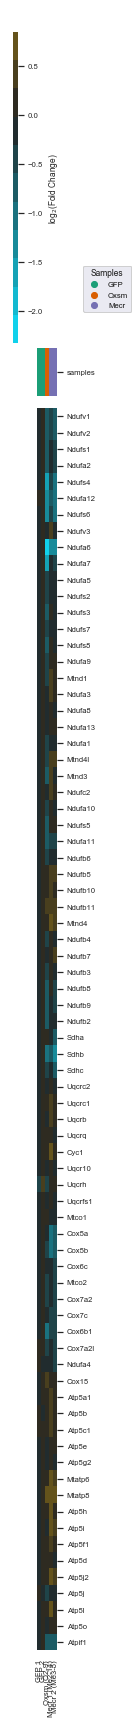

In [11]:
df_all_fc_nodups = df_all_fc[~df_all_fc.index.duplicated()]
df_all_fc_heat = df_all_fc_nodups.reindex(labels=etc,axis=0)
df_all_fc_heat = df_all_fc_heat.dropna(axis=0)

# Get sample info 
info = pd.DataFrame()
info[0] = [
    'GFP 1',
    'GFP 2',
    'Oxsm (O2-9)',
    'Mecr 1 (Me2-14)',
    'Mecr 2 (Me3-8)',
]
info[1] = [
    'GFP',
    'GFP',
    'Oxsm',
    'Mecr',
    'Mecr'
]

#Create a samples color dictionary for plots
colors = {
    'GFP':'#1b9e77',
    'Oxsm':'#d95f02',
    'Mecr':'#7570b3'}

xp.heatmap(
    df_all_fc_heat, 
    info, 
    sample_palette=colors,
    figsize=(1.3,24),
    row_cluster=False, 
    col_cluster=False, 
    font_scale=.7,
    cbar_kws={
        'label': 'log$_2$(Fold Change)',
        'shrink': 0.2, 
        'aspect': 10})

import matplotlib
import matplotlib.pyplot

f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(colors.values())[i]) for i in range(len(list(colors.values())))]
first_legend = plt.legend(handles, list(colors.keys()), bbox_to_anchor=(15, 0.25), loc=2, borderaxespad=0., title='Samples')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

ax.figure.savefig(
    "all_FC_heatmap.pdf", 
    dpi=1800,  
    bbox_inches='tight')

<b><u>VOLCANO PLOTS</u></b>

In [12]:
mecr_meta = {}
for x in df_mecr.columns:
    mecr_meta[x] = x[:3]
    
df_mecr_nodups = df_mecr[~df_mecr.index.duplicated()]
df_mecr_nodups = df_mecr_nodups.dropna(axis=0)

mecr_meta = pd.DataFrame.from_dict(mecr_meta, orient='index', columns=['0'])
mecr_meta = mecr_meta.reset_index()
mecr_meta.columns = [0,1]

del df_mecr_nodups.index.name

<Figure size 432x288 with 0 Axes>

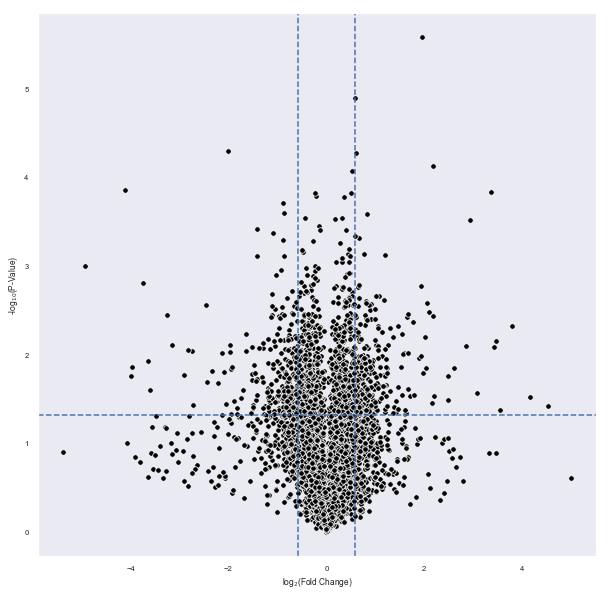

In [13]:
xp.volcano(
    df_mecr_nodups, 
    mecr_meta, 
    'MEC', 
    'GFP', 
    y_threshold=1.32, 
    x_threshold=[-0.59,0.59])

<Figure size 432x288 with 0 Axes>

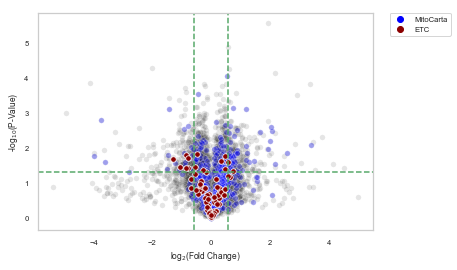

In [14]:
xp.volcano(
    df_mecr_nodups, 
    mecr_meta, 
    'MEC', 
    'GFP', 
    highlight_points=[volcano_mitocarta,etc],
    highlight_color=[
        'Blue',
        'DarkRed'],
    highlight_names=[
        'MitoCarta',
        'ETC'], 
    alpha=.1, 
    alpha_highlights=[0.3,1], 
    y_threshold=1.31, 
    x_threshold=[-0.59,0.59], 
    threshold_color='g',
    dpi=1800, 
    figsize=(6,4), 
    save_fig='mecr_volcano.pdf', 
    whitegrid=True)#,
    #label_points={
    #    'Ndufa12':[-2.5,2.3],
    #    'Ndufa6':[-2.7,1.9],
    #    'Sdhb':[-2.5,1.5],
    #    'Cox5b':[-2,0.90],
    #    'Atpif1':[-1,2.7],
    #    'Cox5a':[-0.3,2.2],
    #    'Mtatp8':[1.3,1.4]})

#### Generate interactive Mecr volcano plot

<Figure size 432x288 with 0 Axes>

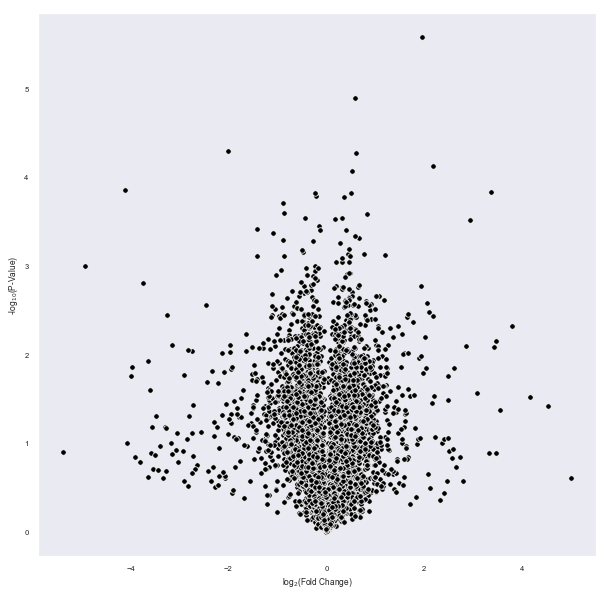

'/Users/jordan/Desktop/collaborations/mtfas_nowinski/mecr_interactive.html'

In [15]:
# Get X and Y data
data = xp.volcano(
    df_mecr_nodups, 
    mecr_meta, 
    'MEC', 
    'GFP',  
    return_data=True)

# Prep labels
data['names'] = data.index.tolist()
label_list = []

for index, row in data.iterrows():
    
    if row[2] in etc:
        label_list.append('ETC')
    elif row[2] in volcano_mitocarta:
        label_list.append('Mitocarta')
    else:
        label_list.append('Other')

data['label'] = label_list

# Plot
import plotly
import plotly.offline as py
import plotly_express as px

sc = px.scatter(
    data,
    x='log$_2$(Fold Change)',
    y='-log$_1$$_0$(P-Value)',
    hover_name='names',
    color="label",
    color_discrete_map={
        'ETC': "#8b0000",
        'Mitocarta': "#6666ff",
        'Other': "#D3D3D3"
    },
    labels={
        'log$_2$(Fold Change)': 'log<sub>2</sub>(Fold Change)',
        '-log$_1$$_0$(P-Value)': '-log<sub>10</sub>(P-Value)'
    },
    log_x=False,
    log_y=False,
    opacity=0.7,
    width=1400,
    height=1000,
    title="Mecr proteomics")

py.offline.plot(sc, filename='/Users/jordan/Desktop/collaborations/mtfas_nowinski/mecr_interactive.html')